In [1]:
%env CUDA_VISIBLE_DEVICES=2
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
from flax import linen as nn
import optax
jax.devices()

env: CUDA_VISIBLE_DEVICES=2
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


[cuda(id=0)]

In [2]:
class CheckBoardDataset(eqx.Module):
    batch_size: int
    rows: int = 4
    cols: int = 4

    @eqx.filter_jit
    def get_batch(self, key):
        key_x, key_y, key = jr.split(key, 3)
        x = jr.uniform(key_x, (self.batch_size,), minval=-self.cols, maxval=self.cols)
        y = jr.uniform(key_y, (self.batch_size,), minval=-self.rows, maxval=self.rows)
        parity = (jnp.floor(x / 2) + jnp.floor(y / 2)) % 2 == 0
        y = jnp.where(parity, y, -y)
        return key, jnp.stack([x, y], axis=-1)


class CIN(nn.Module):
    @nn.compact
    def __call__(self, x, c):
        dim = x.shape[-1]
        mu = nn.Dense(dim, use_bias=False)(c)
        sigma = nn.softplus(nn.Dense(dim)(c))
        x = nn.LayerNorm()(x)
        return x * sigma + mu


class CNF(nn.Module):
    dim: int = 512
    depth: int = 4

    @nn.compact
    def __call__(self, t, x):
        out_dim = x.shape[-1]
        x = c = jnp.concatenate([x, t], axis=-1)
        for _ in range(self.depth):
            x = nn.Dense(self.dim)(x)
            x = nn.gelu(x)
            x = CIN()(x, c)
        x = nn.Dense(out_dim)(x)
        return x

    def sample_x0(self, key, x):
        return jr.normal(key, x.shape)

    def sample_t(self, key, x):
        return jr.uniform(key, (*x.shape[:1], 1))
        # stable diffusion 3 uses logistic normal distribution
        logit = jr.normal(key, (*x.shape[:1], 1))
        t = jax.lax.logistic(logit)
        return t

    def push(self, x0, n_steps: int = 32):
        xt, dt = [x0], 1 / n_steps
        for t in jnp.arange(0, 1, 1 / n_steps):
            t = t * jnp.ones((*x0.shape[:1], 1))
            xt.append(xt[-1] + dt * self(t, xt[-1]))
        return jnp.stack(xt, axis=0)

    def loss(self, batch):
        key, x1 = batch
        key_x0, key_t = jr.split(key)
        x0 = self.sample_x0(key_x0, x1)
        t = self.sample_t(key_t, x1)
        xt = t * x1 + (1 - t) * x0
        target_flow = x1 - x0
        losses = optax.l2_loss(self(t, xt), target_flow)
        return jnp.mean(losses)

In [3]:
class Trainer(eqx.Module):
    model: nn.Module
    dataset: CheckBoardDataset
    optimizer: optax.GradientTransformation
    epochs: int
    epoch_steps: int

    def init_state(self, key):
        batch = self.dataset.get_batch(key)
        params = self.model.init(key, batch, method='loss')
        opt_state = self.optimizer.init(params)
        return (params, opt_state)

    def train_step(self, state, key):
        params, opt_state = state
        batch = self.dataset.get_batch(key)

        loss_fn = lambda par: self.model.apply(par, batch, method='loss')
        loss, grads = jax.value_and_grad(loss_fn)(params)

        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss

    @eqx.filter_jit
    def train_epoch(self, state, key):
        keys = jr.split(key, self.epoch_steps)
        state, losses = jax.lax.scan(self.train_step, state, keys)
        return state, losses

    def fit(self, key):
        key_init, *keys_epochs = jr.split(key, self.epochs+1)
        (params, opt_state) = self.init_state(key_init)
        log = []
        for key in (pbar := tqdm(keys_epochs)):
            (params, opt_state), losses = self.train_epoch((params, opt_state), key)
            pbar.set_postfix(loss=losses.mean())
            log.append(float(losses.mean()))
        log = jnp.array(log)
        return self.model.bind(params), params, log

In [4]:
trainer = Trainer(  
    model=CNF(dim=512, depth=4),
    dataset=CheckBoardDataset(batch_size=1024),
    optimizer=optax.adam(1e-5),
    epochs=1000,
    epoch_steps=128,
)

100%|██████████| 1000/1000 [01:42<00:00,  9.73it/s, loss=1.6885138]


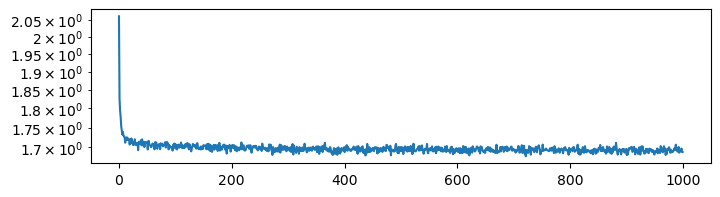

In [5]:
flow, params, losses = trainer.fit(jr.key(0))
plt.figure(figsize=(8, 2))
plt.semilogy(losses)
plt.show()

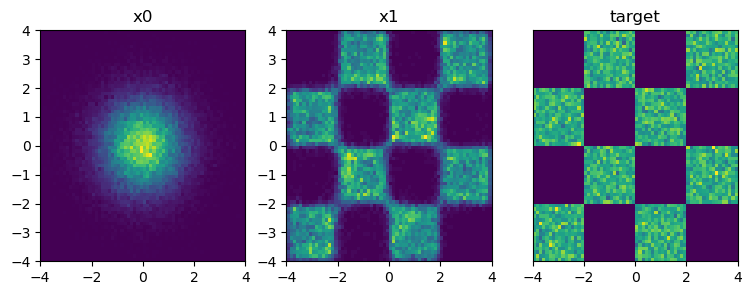

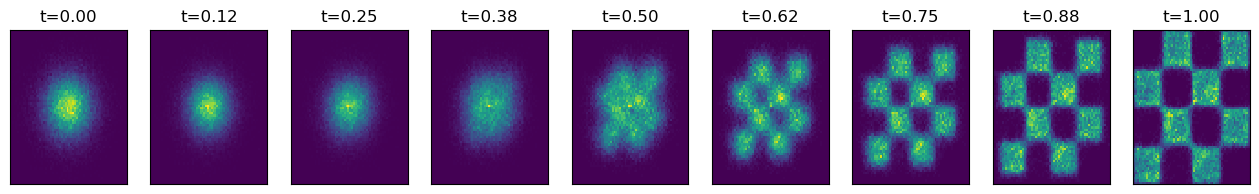

In [6]:
keys, x1 = jax.vmap(trainer.dataset.get_batch)(jr.split(jr.key(0), 64))
x1 = jnp.concatenate(x1, axis=0)
x0 = trainer.model.sample_x0(jr.key(0), x1)
xt = flow.push(x0, n_steps=64)
plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.title('x0')
plt.hist2d(*x0.T, bins=64, range=[[-4, 4], [-4, 4]])
plt.subplot(132)
plt.title('x1')
plt.hist2d(*xt[-1].T, bins=64, range=[[-4, 4], [-4, 4]])
plt.subplot(133)
plt.title('target')
plt.hist2d(*x1.T, bins=64, range=[[-4, 4], [-4, 4]])
plt.yticks([])
plt.show()

plt.figure(figsize=(8*2, 2))
for i, x in enumerate(xt[::len(xt)//8]):
    title = f't={i/(8):.2f}'
    plt.subplot(1, 9, i+1)
    plt.title(title)
    plt.hist2d(*x.T, bins=64, range=[[-4, 4], [-4, 4]])
    plt.xticks([])
    plt.yticks([])
plt.show()